Let's train the guy

In [4]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm as tqdm
tf.keras.backend.set_floatx('float32')
from collections import deque
from datetime import datetime
import random
import matplotlib
from environment import Environment
from plots import just_plot
from misc import *
from nets import *
from buffer import ReplayBuffer


amplitude=0.4
tau = 0.1
lr_critic = 10**-3
lr_actor=10**-2
noise_displacement = .25
ep_guess=0.01
dolinar_layers=1
number_phases=2
buffer_size = 10**7


env = Environment(amplitude=amplitude, dolinar_layers = dolinar_layers, number_phases=number_phases)
buffer = ReplayBuffer(buffer_size=buffer_size)

critic = Critic(nature="primary",valreg=0.01, dolinar_layers = dolinar_layers, number_phases=number_phases)
critic_target = Critic(nature="target", dolinar_layers = dolinar_layers, number_phases=number_phases, tau = tau)
actor = Actor(nature="primary", dolinar_layers = dolinar_layers)
actor_target = Actor(nature="target", dolinar_layers = dolinar_layers)

optimizer_critic = tf.keras.optimizers.Adam(lr=lr_critic)
optimizer_actor = tf.keras.optimizers.Adam(lr=lr_actor)

policy_evaluator = PolicyEvaluator(amplitude = amplitude, dolinar_layers=dolinar_layers, number_phases = number_phases)

expes = np.load("buffers/1L-stoch.npy")

for k in tqdm(expes):
    buffer.add(tuple(k))
    
loss_ev = {}
loss_ev["[]"] = [] 
for outcome in [0.,1.]:
    for guess_index in [0.,1.]:
        loss_ev[str(outcome)+str(guess_index)] = []

betas = np.arange(.1,1.1,.05)
inps = np.stack([np.ones(len(betas))*critic.pad_value, betas], axis=1)
inps = np.reshape(inps, (len(betas),1,2))


100%|██████████| 5000/5000 [00:00<00:00, 537097.78it/s]


In [5]:
def append_preds(loss_ev):       
    loss_ev["[]"].append(np.mean(np.square(ps_maxlik(betas) - np.squeeze(critic(inps)))))
    for outcome in [0.,1.]:
       for guess_index in [0.,1.]:
            m=[]
            for k in tf.unstack(inps):
                m.append(tf.concat([k, np.reshape(np.array([outcome,guess_index]), (1,2))], axis=0))
            loss_ev[str(outcome)+str(guess_index)].append(np.mean(np.square([qval(b, 1, -1) for b in betas] - np.squeeze(critic(tf.stack(m, axis=0)))[:,1])))
    return

In [6]:

total_episodes = 10**3

for k in tqdm(range(total_episodes)):

    samples, zerolabs = critic_target.process_sequence_tf(buffer.sample(64).astype(np.float32))
    labels_critic = critic_target.give_td_errors_tf( samples, zerolabs)
    loss_critic = step_critic_tf(samples ,labels_critic, critic, optimizer_critic)
    critic_target.update_target_parameters(critic)
    
    if k%int(total_episodes/10)==1:
        append_preds(loss_ev)


  0%|          | 1/1000 [00:07<1:57:08,  7.04s/it]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 1000/1000 [01:07<00:00, 14.76it/s]


In [13]:
for k, i in enumerate(loss_ev.keys()):
    print(k,i)

0 []
1 0.00.0
2 0.01.0
3 1.00.0
4 1.01.0


In [25]:

def plot(loss_ev):
    plt.figure(figsize=(30,10))
    nplots = len(loss_ev.keys())
    ax = {}
    for k in range(nplots):
        ax[str(k)] = plt.subplot2grid((1,nplots),(0,k))
    

    episodes = np.arange(1,len(loss_ev["[]"])+1)
    for k, i in enumerate(loss_ev.keys()):
        ax[str(k)].plot(episodes, loss_ev[i], label=str(i))
        
    for k in range(nplots):
        ax[str(k)].legend()
    

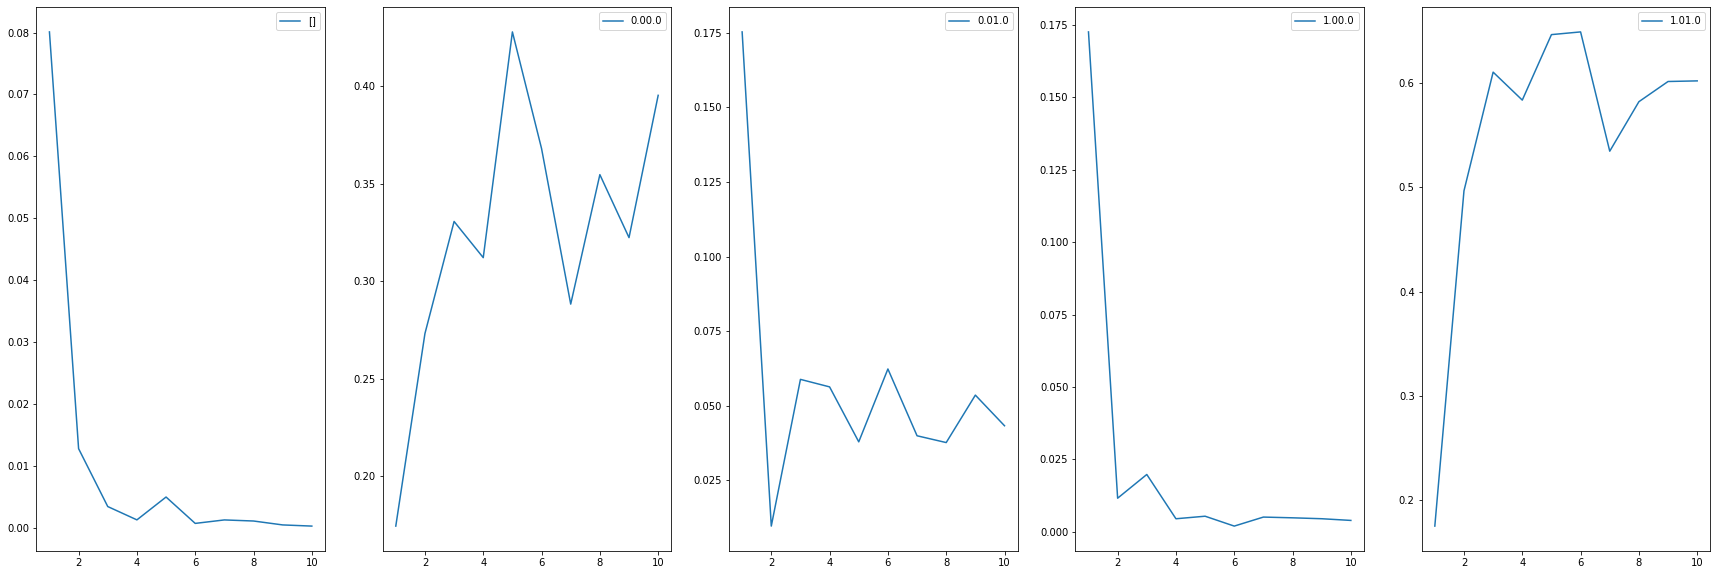

In [26]:
plot(loss_ev)